# Example Figures for Manuscript

Show cutoff method and compare to consensus distribution results

# Inputs

In [2]:
import rnaseq_lib3 as r
import pandas as pd
import scipy.stats as st
import pymc3 as pm
import numpy as np
import time
import os
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

In [4]:
out_dir = '/mnt/research_serializations/Prostate-Figures-For-Paper'

In [58]:
group = 'tissue'

In [123]:
from sklearn.metrics import pairwise_distances
# Get pairwise distances for each group
dist = pairwise_distances(np.array(sample[genes]).reshape(1, -1), gtex[genes])
dist = pd.DataFrame([dist.ravel(), gtex[group]]).T
dist.columns = ['Distance', 'Group']
dist = dist.sort_values('Distance').reset_index(drop=True)

# Pandas-FU
dist = dist.groupby('Group').apply(lambda x: np.median(x.index)).reset_index(name='MedianRank')
dist['MedianRank_norm'] = dist['MedianRank']  gtex[group].value_counts(sort=False).values

# Find Sample

The ideal sample would have:
- High rank to nearest tissue
- Good examples of
    - Just shy of cutoff (and IS outlier)
    - Sample above cutoff (and in agreement)
    - Obvious non-outlier
    - Sample is cutoff (and is NOT outlier due to shape)

In [152]:
sample_dir = '/mnt/outlier-runs/tcga-run/'
samples = os.listdir(sample_dir)

In [153]:
sample_id = np.random.choice(samples)
sample = tumor.loc[sample_id]
print(f'{sample_id} - {sample.tissue}')

ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]
ranks.head(5)

TCGA-DJ-A2PX-01 - Thyroid


,Group,MedianRank
0,Thyroid,150.0
1,Minor,610.0
2,Lung,687.0
3,Breast,868.0
4,Adrenal,1344.0


Outlier: MET
Outlier: MS4A1
Outlier: PIK3CB
Outlier: ROS1
Outlier: STAT1


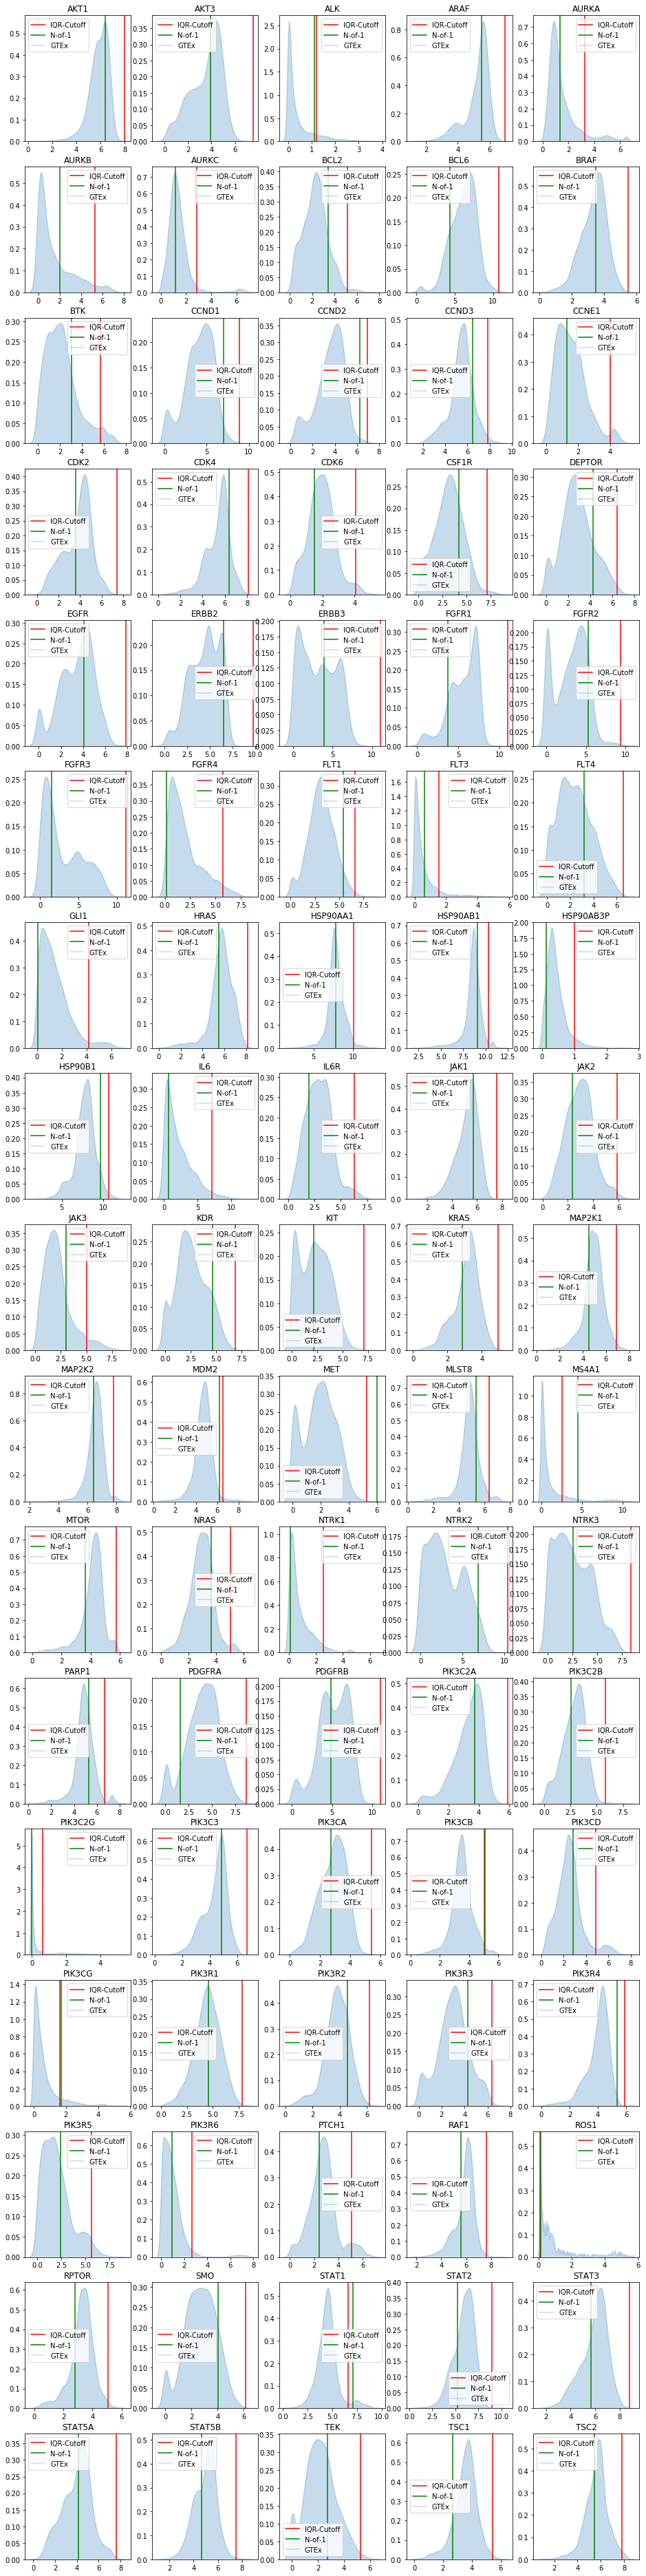

In [154]:
f, ax = plt.subplots(17, 5, figsize=(16, 4 * 17))
ax = ax.flatten()
for i, gene in enumerate(sorted(drug_genes)):
    _, upper = r.math.iqr_bounds(gtex[gene])
    if sample[gene] > upper:
        print(f'Outlier: {gene}')
    ax[i].axvline(upper, c='r', label='IQR-Cutoff')
    ax[i].axvline(sample[gene], label='N-of-1', c='g')
    sns.kdeplot(gtex[gene], label='GTEx', shade=True, alpha=0.25, ax=ax[i])
    ax[i].set_title(gene)

In [155]:
candidates = ['ALK', 'MET', 'MS4A1', 'PIK3CB', 'ROS1', 'STAT1', 'CCND2', 'MDM2', 'PIK3CG']

# Thyroid Sample

In [157]:
sample_id = 'TCGA-DJ-A2PX-01'
sample = tumor.loc[sample_id]
print(f'{sample_id} - {sample.tissue}')

ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]
ranks.head(5)

TCGA-DJ-A2PX-01 - Thyroid


,Group,MedianRank
0,Thyroid,150.0
1,Minor,610.0
2,Lung,687.0
3,Breast,868.0
4,Adrenal,1344.0


## Gene Candidates

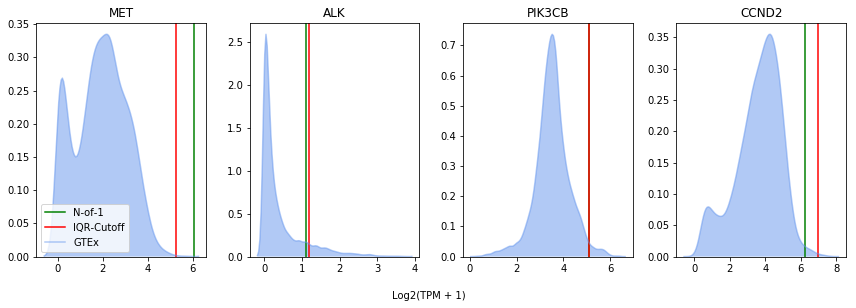

In [174]:
candidates = ['MET', 'ALK', 'PIK3CB', 'CCND2']
f, ax = plt.subplots(1, 4, figsize=(12, 4))
ax = ax.flatten()
for i, gene in enumerate(candidates):
    _, upper = r.math.iqr_bounds(gtex[gene])
    ax[i].axvline(sample[gene], label='N-of-1', c='g')
    ax[i].axvline(upper, c='r', label='IQR-Cutoff')
    sns.kdeplot(gtex[gene], label='GTEx', ax=ax[i], shade=True, alpha=0.5, c='cornflowerblue')
    ax[i].set_title(gene)
    if i != 0:
        ax[i].get_legend().remove()
f.text(0.5, -0.05, 'Log2(TPM + 1)', ha='center') 
plt.tight_layout()

## Load Model

In [3]:
sample_dir = '/mnt/outlier-runs/example-for-paper/TCGA-DJ-A2PX-01/'
m, t = r.outlier.load_model(os.path.join(sample_dir, 'model.pkl'))

## Traceplot

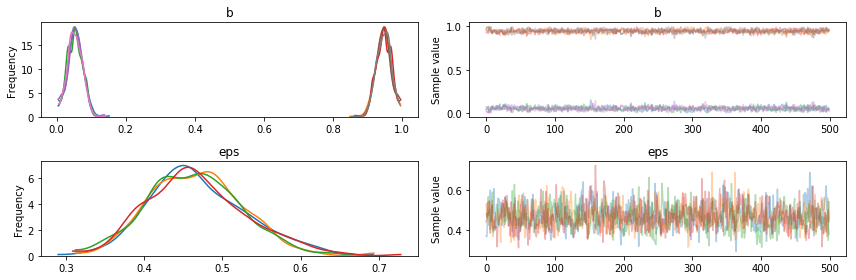

In [14]:
pm.traceplot(t, varnames=['b', 'eps']);

## Weights

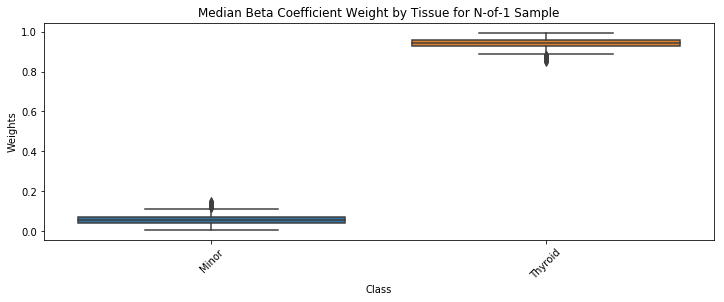

In [6]:
r.outlier.plot_weights(['Minor', 'Thyroid'], t)
plt.xticks(rotation=45);

## Posterior

In [12]:
sample = tumor.loc['TCGA-DJ-A2PX-01']
ppc = r.outlier.ppc(t, drug_genes)
ppp = r.outlier.posterior_predictive_pvals(sample, ppc)

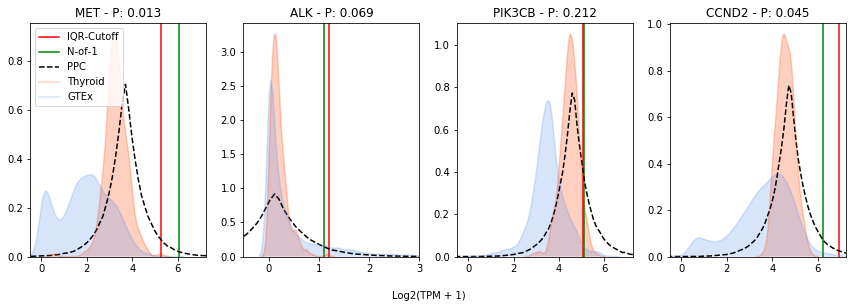

In [23]:
candidates = ['MET', 'ALK', 'PIK3CB', 'CCND2']
f, ax = plt.subplots(1, 4, figsize=(12, 4))
ax = ax.flatten()
for i, gene in enumerate(candidates):
    _, upper = r.math.iqr_bounds(gtex[gene])
    ax[i].axvline(upper, c='r', label='IQR-Cutoff')
    ax[i].axvline(sample[gene], c='g', label='N-of-1')
    sns.kdeplot(ppc[gene], label='PPC', ax=ax[i], ls='--', c='k')
    sns.kdeplot(gtex[gtex.tissue == sample.tissue][gene], ax=ax[i], shade=True, alpha=0.25, label=sample.tissue, c='orangered')
    sns.kdeplot(gtex[gene], label='GTEx', ax=ax[i], shade=True, alpha=0.25, c='cornflowerblue')
    ax[i].set_title(f'{gene} - P: {round(ppp[gene], 3)}')
    if i != 1:
        ax[i].set_xlim([-0.5, 7.25])
    else:
        ax[i].set_xlim([-0.5, 3])
    #ax[i].set_xlabel('Log2(TPM + 1)')
    if i != 0:
        ax[i].get_legend().remove()
    else:
        ax[i].legend(loc='upper left')
f.text(0.5, -0.05, 'Log2(TPM + 1)', ha='center')
plt.tight_layout()

- Missed Outlier
    - CCND2
- Disagreed Outlier
    - PIK3CB
- Agreed Outlier
    - MET
- Agreed Non-Outlier
    - ALK

# Liver Sample

In [ ]:
sample_id = 'TCGA-DD-AACU-01'
sample = tumor.loc[sample_id]
print(f'{sample_id} - {sample.tissue}')

ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]
ranks.head(5)

## Drug Genes

In [149]:
candidates = ['MET', 'MTOR', 'SMO', 'FGFR4', 'PIK3C2G',]

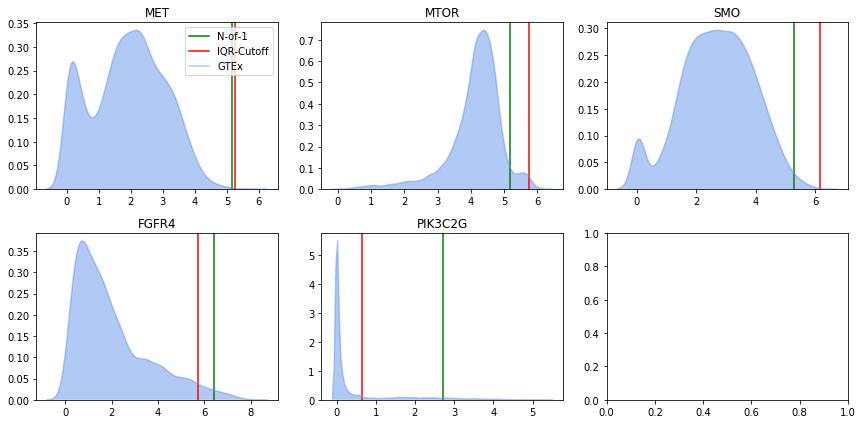

In [150]:
f, ax = plt.subplots(2, 3, figsize=(12, 6))
ax = ax.flatten()
for i, gene in enumerate(candidates):
    _, upper = r.math.iqr_bounds(gtex[gene])
    ax[i].axvline(sample[gene], label='N-of-1', c='g')
    ax[i].axvline(upper, c='r', label='IQR-Cutoff')
    sns.kdeplot(gtex[gene], label='GTEx', ax=ax[i], shade=True, alpha=0.5, c='cornflowerblue')
    ax[i].set_title(gene)
    if i != 0:
        ax[i].get_legend().remove()
plt.tight_layout()

## Load Model

In [131]:
m, t = r.outlier.load_model(os.path.join(sample_dir, sample_id, 'model.pkl'))

## Traceplot

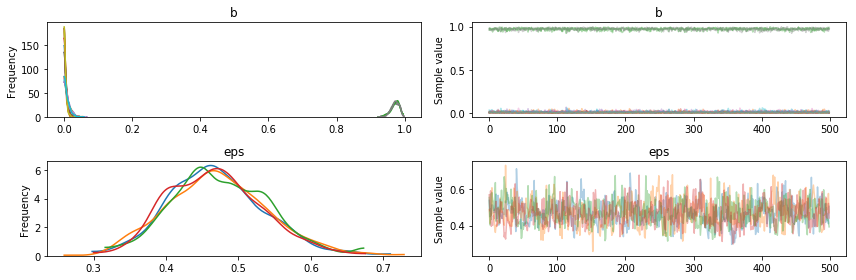

In [134]:
pm.traceplot(t, varnames=['b', 'eps']);

## Weights

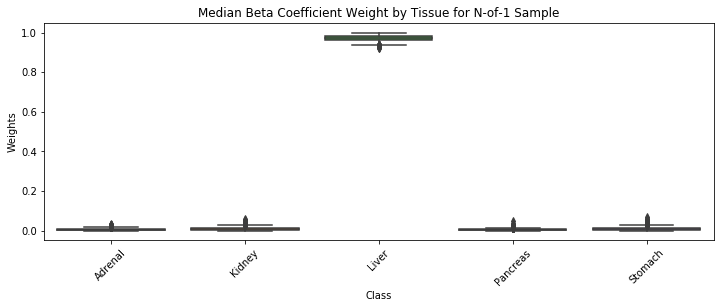

In [136]:
r.outlier.plot_weights(training_group.tissue.unique(), t)
plt.xticks(rotation=45);

## Posterior

In [137]:
ppc = r.outlier.ppc(t, drug_genes)
ppp = r.outlier.posterior_predictive_pvals(sample, ppc)

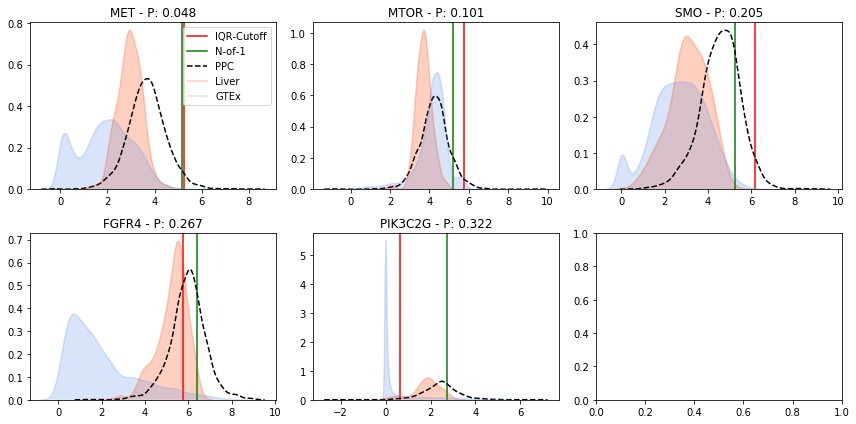

In [151]:
f, ax = plt.subplots(2, 3, figsize=(12, 6))
ax = ax.flatten()
for i, gene in enumerate(candidates):
    _, upper = r.math.iqr_bounds(gtex[gene])
    ax[i].axvline(upper, c='r', label='IQR-Cutoff')
    ax[i].axvline(sample[gene], c='g', label='N-of-1')
    sns.kdeplot(ppc[gene], label='PPC', ax=ax[i], ls='--', c='k')
    sns.kdeplot(gtex[gtex.tissue == sample.tissue][gene], ax=ax[i], shade=True, alpha=0.25, label=sample.tissue, c='orangered')
    sns.kdeplot(gtex[gene], label='GTEx', ax=ax[i], shade=True, alpha=0.25, c='cornflowerblue')
    ax[i].set_title(f'{gene} - P: {round(ppp[gene], 3)}')
    if i != 0:
        ax[i].get_legend().remove()
plt.tight_layout()

# Adrenal Sample

Pick 3/4 druggable genes to demonstrate the following:
- Sample
    - TCGA-OR-A5J2-01
- Sample just short of cutoff but looks like outlier
    - CDK4
    - CCND2
    - CCNE1
- Sample just above cutoff
    - AURKA
    - CDK6
- Sample far short of cutoff but looks like outlier 
    - CCND1
- Obvious non-outlier
    - ARAF

## Pick Candidate Genes

In [5]:
sample_id = np.random.choice(tumor[tumor.subtype == 'Adrenocortical_Carcinoma'].id)
sample_id = 'TCGA-OR-A5J2-01'
sample = tumor.loc[sample_id]

ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
ranks.head(5)

,Group,MedianRank
0,Adrenal,63.0
1,Ovary,1397.5
2,Adipose,1498.0
3,Breast,1562.0
4,Artery,1870.0


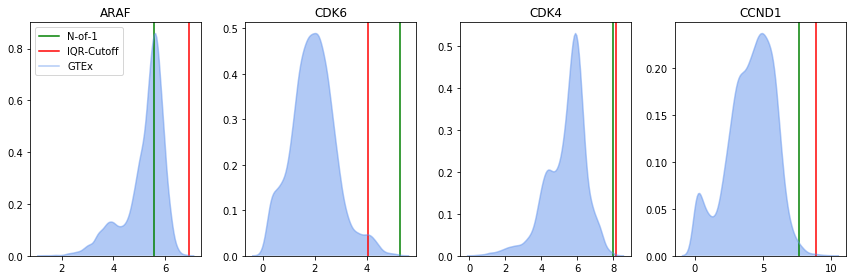

In [19]:
#candidates = ['ARAF', 'CDK4', 'CCND2', 'CCNE1', 'AURKA', 'CDK6', 'CCND1']
candidates = ['ARAF', 'CDK6', 'CDK4', 'CCND1']

f, ax = plt.subplots(1, 4, figsize=(12, 4))
ax = ax.flatten()
for i, gene in enumerate(candidates):
    _, upper = r.math.iqr_bounds(gtex[gene])
    ax[i].axvline(sample[gene], label='N-of-1', c='g')
    ax[i].axvline(upper, c='r', label='IQR-Cutoff')
    sns.kdeplot(gtex[gene], label='GTEx', ax=ax[i], shade=True, alpha=0.5, c='cornflowerblue')
    ax[i].set_title(gene)
    if i != 0:
        ax[i].get_legend().remove()
plt.tight_layout()

## Run Outlier Model

### Picking Training Group and Training Genes

In [8]:
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

training_genes = r.outlier.select_k_best_genes(training_group, genes, n=40)
training_genes = list(set(training_genes + drug_genes))
len(training_genes)

125

### Run Model

In [9]:
out = os.path.join(out_dir, f'{sample.id}-drug-genes-40.pkl')
if os.path.exists(out):
    m, t = r.outlier.load_model(out)
else:
    m, t = r.outlier.run_model(sample, training_group, training_genes, 'tissue')
    r.outlier.pickle_model(out, m, t)

## Traceplots

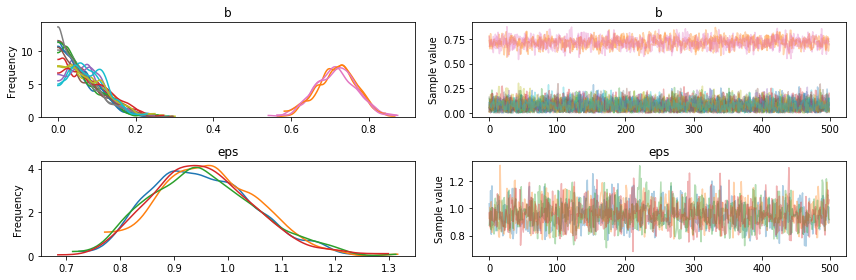

In [10]:
pm.traceplot(t, varnames=['b', 'eps']);

## Weights

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

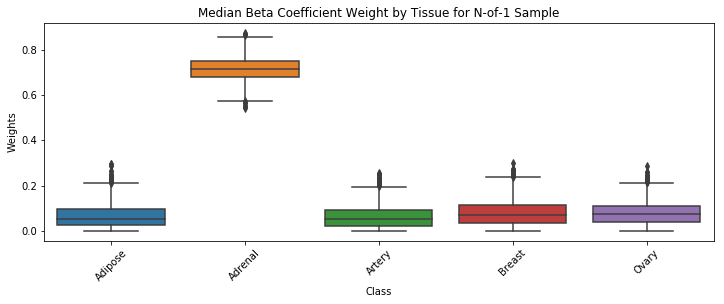

In [11]:
r.outlier.plot_weights(training_group.tissue.unique(), t)
plt.xticks(rotation=45)

## Posterior Distributions

In [12]:
ppc = r.outlier.ppc(t, drug_genes)
ppp = r.outlier.posterior_predictive_pvals(sample, ppc)

In [13]:
candidates = ['ARAF', 'CDK6', 'CDK4', 'CCND1']

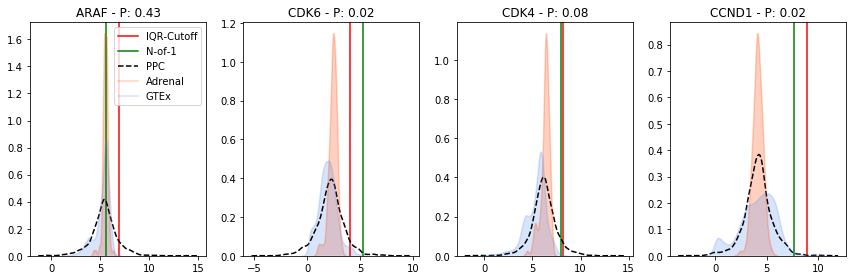

In [21]:
f, ax = plt.subplots(1, 4, figsize=(12, 4))
ax = ax.flatten()
for i, gene in enumerate(candidates):
    _, upper = r.math.iqr_bounds(gtex[gene])
    ax[i].axvline(upper, c='r', label='IQR-Cutoff')
    ax[i].axvline(sample[gene], c='g', label='N-of-1')
    sns.kdeplot(ppc[gene], label='PPC', ax=ax[i], ls='--', c='k')
    sns.kdeplot(gtex[gtex.tissue == 'Adrenal'][gene], ax=ax[i], shade=True, alpha=0.25, label='Adrenal', c='orangered')
    sns.kdeplot(gtex[gene], label='GTEx', ax=ax[i], shade=True, alpha=0.25, c='cornflowerblue')
    ax[i].set_title(f'{gene} - P: {round(ppp[gene], 2)}')
    if i != 0:
        ax[i].get_legend().remove()
plt.tight_layout()